<a href="https://colab.research.google.com/github/DragonFarts/Video-EZY/blob/main/Vid2Denspose_and_(zcxu_eric_magicanimate).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://huggingface.co/spaces/zcxu-eric/magicanimate /content/magicanimate

Cloning into '/content/magicanimate'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 152 (delta 38), reused 0 (delta 0), pack-reused 4
Receiving objects: 100% (152/152), 5.51 MiB | 10.43 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [ ]:
!pip install -r /content/magicanimate/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.8/201.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.1/26.1 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 

In [ ]:
%cd /content/magicanimate/

In [ ]:
!python /content/magicanimate/app.py

2023-12-05 01:40:00.037993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 01:40:00.038056: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 01:40:00.038084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 01:40:01.367269: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/content/magicanimate/magicanimate/pipelines/pipeline_animation.py:43: FutureWarning: Importing `DiffusionPipeline` or `ImagePipelineOutput` from diffusers.pipeline_utils is deprecated. Please import from diffusers.pipelines.pipeline_util

In [ ]:
%%writefile /content/magicanimate/app.py
import argparse
import imageio
import numpy as np
import gradio as gr
from PIL import Image
import os
from pathlib import Path

from demo.animate import MagicAnimate
from huggingface_hub import snapshot_download

snapshot_download(repo_id="runwayml/stable-diffusion-v1-5", local_dir="./stable-diffusion-v1-5")
snapshot_download(repo_id="stabilityai/sd-vae-ft-mse", local_dir="./sd-vae-ft-mse")
snapshot_download(repo_id="zcxu-eric/MagicAnimate", local_dir="./MagicAnimate")

animator = MagicAnimate()

def animate(reference_image, motion_sequence_state, seed, steps, guidance_scale):
    return animator(reference_image, motion_sequence_state, seed, steps, guidance_scale)

def read_video(video, size=512):
    reader = imageio.get_reader(video)
    fps = reader.get_meta_data()['fps']
    assert fps == 25.0, f'Expected video fps: 25, but {fps} fps found'
    return video

def read_image(image, size=512):
    return np.array(Image.fromarray(image).resize((size, size)))

def animate_batch(image_batch_path, motion_sequence_batch_path, seed, steps, guidance_scale):
    image_files = os.listdir(image_batch_path)
    motion_sequence_files = os.listdir(motion_sequence_batch_path)

    results = []
    for image_file in image_files:
        if image_file.endswith('.png') or image_file.endswith('.jpg'):
            image_path = Path(image_batch_path) / image_file
            reference_image = read_image(imageio.imread(str(image_path)))

            for motion_sequence_file in motion_sequence_files:
                if motion_sequence_file.endswith('.mp4'):
                    motion_sequence_path = Path(motion_sequence_batch_path) / motion_sequence_file
                    motion_sequence = read_video(str(motion_sequence_path))
                    result = animate(reference_image, motion_sequence, seed, steps, guidance_scale)
                    results.append(result)

    return results

with gr.Blocks() as demo:
    gr.HTML("""
        <div style="text-align: center; max-width: 1200px; margin: 20px auto;">
        <h1 style="font-weight: 800; font-size: 2rem; margin: 0rem">
            MagicAnimate: Temporally Consistent Human Image Animation
        </h1>
        <br>
        <h2 style="font-weight: 450; font-size: 1rem; margin: 0rem">
            <a href="https://showlab.github.io/magicanimate">Project page</a> |
            <a href="https://github.com/magic-research/magic-animate"> GitHub </a> |
            <a href="https://arxiv.org/abs/2311.16498"> arXiv </a>
        </h2>
        </div>
    """)
    animation = gr.Video(format="mp4", label="Animation Results", autoplay=True)

    with gr.Row():
        reference_image  = gr.Image(label="Reference Image")
        motion_sequence  = gr.Video(format="mp4", label="Motion Sequence")

        with gr.Column():
            random_seed         = gr.Textbox(label="Random seed", value="1", info="default: -1")
            sampling_steps      = gr.Textbox(label="Sampling steps", value="25", info="default: 25")
            guidance_scale      = gr.Textbox(label="Guidance scale", value="7.5", info="default: 7.5")
            submit              = gr.Button("Animate")
            image_batch_path    = gr.Textbox(label="Image Batch Path", placeholder="Enter the path to your image batch files")
            motion_sequence_batch_path = gr.Textbox(label="Motion Sequence Batch Path", placeholder="Enter the path to your motion sequence batch files")
            batch_submit        = gr.Button("Animate Batch")

    motion_sequence.upload(
        read_video,
        motion_sequence,
        motion_sequence
    )

    reference_image.upload(
        read_image,
        reference_image,
        reference_image
    )

    submit.click(
        animate,
        [reference_image, motion_sequence, random_seed, sampling_steps, guidance_scale],
        animation
    )

    batch_submit.click(
        animate_batch,
        [image_batch_path, motion_sequence_batch_path, random_seed, sampling_steps, guidance_scale],
        animation
    )

    gr.Markdown("## Examples")
    gr.Examples(
        examples=[
            ["inputs/applications/source_image/monalisa.png", "inputs/applications/driving/densepose/running.mp4"],
            ["inputs/applications/source_image/demo4.png", "inputs/applications/driving/densepose/demo4.mp4"],
            ["inputs/applications/source_image/0002.png", "inputs/applications/driving/densepose/demo4.mp4"],
            ["inputs/applications/source_image/dalle2.jpeg", "inputs/applications/driving/densepose/running2.mp4"],
            ["inputs/applications/source_image/dalle8.jpeg", "inputs/applications/driving/densepose/dancing2.mp4"],
            ["inputs/applications/source_image/multi1_source.png", "inputs/applications/driving/densepose/multi_dancing.mp4"]
        ],
        inputs=[reference_image, motion_sequence],
        outputs=animation
    )

demo.launch(share=True)


In [ ]:
%%writefile /content/magicanimate/demo/animate.py
import argparse
import argparse
import datetime
import inspect
import os
import numpy as np
from PIL import Image
from omegaconf import OmegaConf
from collections import OrderedDict

import torch

from diffusers import AutoencoderKL, DDIMScheduler, UniPCMultistepScheduler

from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

from magicanimate.models.unet_controlnet import UNet3DConditionModel
from magicanimate.models.controlnet import ControlNetModel
from magicanimate.models.appearance_encoder import AppearanceEncoderModel
from magicanimate.models.mutual_self_attention import ReferenceAttentionControl
from magicanimate.pipelines.pipeline_animation import AnimationPipeline
from magicanimate.utils.util import save_videos_grid
from accelerate.utils import set_seed

from magicanimate.utils.videoreader import VideoReader

from einops import rearrange, repeat

import csv, pdb, glob
from safetensors import safe_open
import math
from pathlib import Path

class MagicAnimate():
    def __init__(self, config="configs/prompts/animation.yaml") -> None:
        print("Initializing MagicAnimate Pipeline...")
        *_, func_args = inspect.getargvalues(inspect.currentframe())
        func_args = dict(func_args)

        config  = OmegaConf.load(config)

        inference_config = OmegaConf.load(config.inference_config)

        motion_module = config.motion_module

        ### >>> create animation pipeline >>> ###
        tokenizer = CLIPTokenizer.from_pretrained(config.pretrained_model_path, subfolder="tokenizer")
        text_encoder = CLIPTextModel.from_pretrained(config.pretrained_model_path, subfolder="text_encoder")
        if config.pretrained_unet_path:
            unet = UNet3DConditionModel.from_pretrained_2d(config.pretrained_unet_path, unet_additional_kwargs=OmegaConf.to_container(inference_config.unet_additional_kwargs))
        else:
            unet = UNet3DConditionModel.from_pretrained_2d(config.pretrained_model_path, subfolder="unet", unet_additional_kwargs=OmegaConf.to_container(inference_config.unet_additional_kwargs))
        self.appearance_encoder = AppearanceEncoderModel.from_pretrained(config.pretrained_appearance_encoder_path, subfolder="appearance_encoder").cuda()
        self.reference_control_writer = ReferenceAttentionControl(self.appearance_encoder, do_classifier_free_guidance=True, mode='write', fusion_blocks=config.fusion_blocks)
        self.reference_control_reader = ReferenceAttentionControl(unet, do_classifier_free_guidance=True, mode='read', fusion_blocks=config.fusion_blocks)
        if config.pretrained_vae_path is not None:
            vae = AutoencoderKL.from_pretrained(config.pretrained_vae_path)
        else:
            vae = AutoencoderKL.from_pretrained(config.pretrained_model_path, subfolder="vae")

        ### Load controlnet
        controlnet   = ControlNetModel.from_pretrained(config.pretrained_controlnet_path)

        vae.to(torch.float16)
        unet.to(torch.float16)
        text_encoder.to(torch.float16)
        controlnet.to(torch.float16)
        self.appearance_encoder.to(torch.float16)

        unet.enable_xformers_memory_efficient_attention()
        self.appearance_encoder.enable_xformers_memory_efficient_attention()
        controlnet.enable_xformers_memory_efficient_attention()

        self.pipeline = AnimationPipeline(
            vae=vae, text_encoder=text_encoder, tokenizer=tokenizer, unet=unet, controlnet=controlnet,
            scheduler=DDIMScheduler(**OmegaConf.to_container(inference_config.noise_scheduler_kwargs)),
            # NOTE: UniPCMultistepScheduler
        ).to("cuda")

        # 1. unet ckpt
        # 1.1 motion module
        motion_module_state_dict = torch.load(motion_module, map_location="cpu")
        if "global_step" in motion_module_state_dict: func_args.update({"global_step": motion_module_state_dict["global_step"]})
        motion_module_state_dict = motion_module_state_dict['state_dict'] if 'state_dict' in motion_module_state_dict else motion_module_state_dict
        try:
            # extra steps for self-trained models
            state_dict = OrderedDict()
            for key in motion_module_state_dict.keys():
                if key.startswith("module."):
                    _key = key.split("module.")[-1]
                    state_dict[_key] = motion_module_state_dict[key]
                else:
                    state_dict[key] = motion_module_state_dict[key]
            motion_module_state_dict = state_dict
            del state_dict
            missing, unexpected = self.pipeline.unet.load_state_dict(motion_module_state_dict, strict=False)
            assert len(unexpected) == 0
        except:
            _tmp_ = OrderedDict()
            for key in motion_module_state_dict.keys():
                if "motion_modules" in key:
                    if key.startswith("unet."):
                        _key = key.split('unet.')[-1]
                        _tmp_[_key] = motion_module_state_dict[key]
                    else:
                        _tmp_[key] = motion_module_state_dict[key]
            missing, unexpected = unet.load_state_dict(_tmp_, strict=False)
            assert len(unexpected) == 0
            del _tmp_
        del motion_module_state_dict

        self.pipeline.to("cuda")
        self.L = config.L

        print("Initialization Done!")

    def __call__(self, source_image, motion_sequence, random_seed, step, guidance_scale, size=512):
            prompt = n_prompt = ""
            random_seed = int(random_seed)
            step = int(step)
            guidance_scale = float(guidance_scale)
            samples_per_video = []
            # manually set random seed for reproduction
            if random_seed != -1:
                torch.manual_seed(random_seed)
                set_seed(random_seed)
            else:
                torch.seed()

            if motion_sequence.endswith('.mp4'):
                control = VideoReader(motion_sequence).read()
                if control[0].shape[0] != size:
                    control = [np.array(Image.fromarray(c).resize((size, size))) for c in control]
                control = np.array(control)

            if source_image.shape[0] != size:
                source_image = np.array(Image.fromarray(source_image).resize((size, size)))
            H, W, C = source_image.shape

            init_latents = None
            original_length = control.shape[0]
            if control.shape[0] % self.L > 0:
                control = np.pad(control, ((0, self.L-control.shape[0] % self.L), (0, 0), (0, 0), (0, 0)), mode='edge')
            generator = torch.Generator(device=torch.device("cuda:0"))
            generator.manual_seed(torch.initial_seed())
            sample = self.pipeline(
                prompt,
                negative_prompt         = n_prompt,
                num_inference_steps     = step,
                guidance_scale          = guidance_scale,
                width                   = W,
                height                  = H,
                video_length            = len(control),
                controlnet_condition    = control,
                init_latents            = init_latents,
                generator               = generator,
                appearance_encoder       = self.appearance_encoder,
                reference_control_writer = self.reference_control_writer,
                reference_control_reader = self.reference_control_reader,
                source_image             = source_image,
            ).videos

            source_images = np.array([source_image] * original_length)
            source_images = rearrange(torch.from_numpy(source_images), "t h w c -> 1 c t h w") / 255.0
            samples_per_video.append(source_images)

            control = control / 255.0
            control = rearrange(control, "t h w c -> 1 c t h w")
            control = torch.from_numpy(control)
            samples_per_video.append(control[:, :, :original_length])

            samples_per_video.append(sample[:, :, :original_length])

            samples_per_video = torch.cat(samples_per_video)

            time_str = datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
            savedir = "/content/drive/MyDrive/#magicout"  # Updated save directory
            animation_path = f"{savedir}/{time_str}.mp4"

            os.makedirs(savedir, exist_ok=True)
            save_videos_grid(samples_per_video, animation_path)

            return animation_path


# **Create a DensePose video**

##**Vid2DensePose by Flode Labs**
Convert your videos easily to Densepose sequences

If you have any problem with the colab let us know via [X.com](https://x.com/flodelabs)

###**Install the libraries**

In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 15285, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15285 (delta 2), reused 5 (delta 0), pack-reused 15275
Receiving objects: 100% (15285/15285), 6.18 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (11116/11116), done.


In [ ]:
!pip install torch==2.1.0 torchvision==0.16.0 opencv-python git+https://github.com/facebookresearch/detectron2@main#subdirectory=projects/DensePose

  Cloning https://github.com/facebookresearch/detectron2 (to revision main) to /tmp/pip-req-build-ag95u10e
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2 /tmp/pip-req-build-ag95u10e
  Resolved https://github.com/facebookresearch/detectron2 to commit 5de5319a49e7ea819586d3d6a817632392dfdeb2
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-install-7owu46k2/detectron2_416f2ad8815a4c1184eab8e765d5fc87
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-7owu46k2/detectron2_416f2ad8815a4c1184eab8e765d5fc87
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5de5319a49e7ea819586d3d6a817632392dfdeb2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.8 MB/s 

###**Convert your videos**

Upload the video you want to convert pressing the top left icon on the files section and then especify its name and the output name you desired on the next step.

 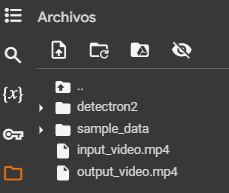

In [ ]:
from detectron2.config import get_cfg
import torch
import cv2
import numpy as np
from detectron2.engine import DefaultPredictor
from densepose import add_densepose_config
from densepose.vis.extractor import DensePoseResultExtractor
from densepose.vis.densepose_results import DensePoseResultsFineSegmentationVisualizer as Visualizer

# Initialize Detectron2 configuration for DensePose
cfg = get_cfg()
add_densepose_config(cfg)
cfg.merge_from_file("detectron2/projects/DensePose/configs/densepose_rcnn_R_50_FPN_s1x.yaml")
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl"
predictor = DefaultPredictor(cfg)

# Video paths
INPUT_VIDEO_PATH = "/content/20231206_063030.mp4" #@param {type:"raw"}
OUTPUT_VIDEO_PATH = "/content/dp_20231206_063030.mp4" #@param {type:"raw"}

# Open the input video
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (width, height))

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    with torch.no_grad():
        outputs = predictor(frame)['instances']

    results = DensePoseResultExtractor()(outputs)
    out_frame = Visualizer(alpha=1).visualize(np.zeros(frame.shape, dtype=np.uint8), results)

    out.write(out_frame)

# Release resources
cap.release()
out.release()


In [ ]:
import os
from os.path import exists, join, basename, splitext

#@markdown ### ▶️ Setup
#@markdown Run this first.
if not os.path.exists('/content/drive'):
  from google.colab import drive
  print("📂 Connecting to Google Drive...")
  drive.mount('/content/drive')

!pip install controlnet_aux
!pip install diffusers transformers accelerate
!pip install ffmpeg-python


gDir = "/content/drive/MyDrive/openpose"

if not os.path.exists('/content/drive/MyDrive/openpose'):
  !mkdir '/content/drive/MyDrive/openpose'



📂 Connecting to Google Drive...
Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for controlnet_aux: filename=controlnet_aux-0.0.7-py3-none-any.whl size=274340 sha256=800877f982f755edebeffb9e94728e9619e05123116c2265c220951ee75c1e33
  Stored in directory: /root/.cache/pip/wheels/1e/3e/93/6678b4c0bc2ec31d53409b25d4189cbb08bae843e8b2b78e52
Successfully built controlnet_aux


In [ ]:
import ffmpeg
import os
from os.path import exists, join, basename, splitext
from os import listdir
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import OpenposeDetector
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from diffusers.utils import load_image
from tqdm import tqdm

!rm -fr /content/frames

#@markdown ### ▶️ Process Video
#@markdown Video to process
video_file = "/content/Bubble Butt (3).mp4" #@param {type:"string"}

#@markdown Where to save your output under My Drive/openpose. Spaces aren't allowed.
project_name = "dancing" #@param {type:"string"}
gDir = "/content/drive/MyDrive/openpose"

outputDir = os.path.join(gDir, project_name)

if not os.path.exists(outputDir):
  !mkdir {outputDir}

folder_dir = '/content/frames'

if not os.path.exists(folder_dir):
  !mkdir {folder_dir}
print("Extracting frames")
images_dir = os.path.join(folder_dir, 'frames-%d.jpg' )
#chop up video with ffmpeg
out, err = (
    ffmpeg
    .input(video_file, ss = 0, r = 1)
    # .filter('fps', fps='25')
    .output('/content/frames/test-%04d.jpg', start_number=0)
    .overwrite_output()
    .run()
)

if err:
  print({err})

# import the modules
openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

ix=0
image_files = os.listdir('/content/frames')
print("Processing frames")
# get the path/directory
for images in tqdm(sorted(image_files)):
    # check if the image ends with png or jpg or jpeg
    if (images.endswith(".png") or images.endswith(".jpg")\
        or images.endswith(".jpeg")):

        filename = 'frame-' + f'{ix:05d}' + '.jpg'
        ix = ix + 1
        #print(images)
        outfile = os.path.join(outputDir, filename)
        #print(outfile)
        image = load_image('/content/frames/' + images)
        image = openpose(image)
        image.save(outfile)



Extracting frames
Processing frames


100%|██████████| 71/71 [00:58<00:00,  1.21it/s]


In [ ]:
import os
from os.path import exists, join, basename, splitext
from os import listdir
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from controlnet_aux import OpenposeDetector
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from diffusers.utils import load_image
from tqdm import tqdm

!rm -fr /content/frames

#@markdown ### ▶️ Process Folder
#@markdown Folder to process
folder_name = "" #@param {type:"string"}

outputDir = os.path.join(folder_name, 'controlnet')

if not os.path.exists(outputDir):
  !mkdir {outputDir}

# import the modules
openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

print("Processing images")
# get the path/directory
for images in tqdm(sorted(os.listdir(folder_name))):
    #print(images)
    # check if the image ends with png or jpg or jpeg
    if (images.endswith(".png") or images.endswith(".jpg")\
        or images.endswith(".jpeg")):

        outfile = os.path.join(outputDir, images)
        #print(outfile)
        image = load_image(os.path.join(folder_name,images))
        image = openpose(image)
        image.save(outfile)


